# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Функция отрисовки аудио сигнала

In [2]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

### Для выполнения задания нам понадобится датасет *yes/no*. 
Про датасет можно почитать тут https://www.openslr.org/1/

In [3]:
# Скачаем его
#  надёжнее использовать скачивание вручную, либо попробовать строчку ниже
![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
!tar -xvzf waves_yesno.tar.gz

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/0_0_1_1_1_0_0_0.wav
waves_yesno/0_1_1_1_1_1_1_1.wav
waves_yesno/0_1_0_1_1_1_0_0.wav
waves_yesno/1_0_1_1_1_0_1_0.wav
waves_yesno/1_0_0_1_0_1_1_1.wav
waves_yesno/0_0_1_0_1_0_0_0.wav
waves_yesno/0_1_0_1_1_0_1_0.wav
waves_yesno/0_0_1_1_0_1_1_0.wav
waves_yesno/1_0_0_0_1_0_0_1.wav
waves_yesno/1_1_0_1_1_1_1_0.wav
waves_yesno/0_0_1_1_1_1_0_0.wav
waves_yesno/1_1_0_0_1_1_1_0.wav
waves_yesno/0_0_1_1_0_1_1_1.wav
waves_yesno/1_1_0_1_0_1_1_0.wav
waves_yesno/0_1_0_0_0_1_1_0.wav
waves_yesno/0_0_0_1_0_0_0_1.wav
waves_yesno/0_0_1_0_1_0_1_1.wav
waves_yesno/0_0_1_0_0_0_1_0.wav
waves_yesno/1_1_0_1_1_0_0_1.wav
waves_yesno/0_1_1_1_0_1_0_1.wav
waves_yesno/0_1_1_1_0_0_0_0.wav
waves_yesno/README~
waves_yesno/0_1_0_0_0_1_0_0.wav
waves_yesno/1_0_0_0_0_0_0_1.wav
waves_yesno/1_1_0_1_1_0_1_1.wav
waves_yesno/1_1_0_0_0_0_0_1.wav
waves_yesno/1_0_0_0_0_0_0_0.wav
waves_y

P.S если у вас Windows, или по каким-либо еще причинам данные не скачались, 
то их можно скачать руками отсюда: https://www.openslr.org/1/

### Загрузим один из файлов

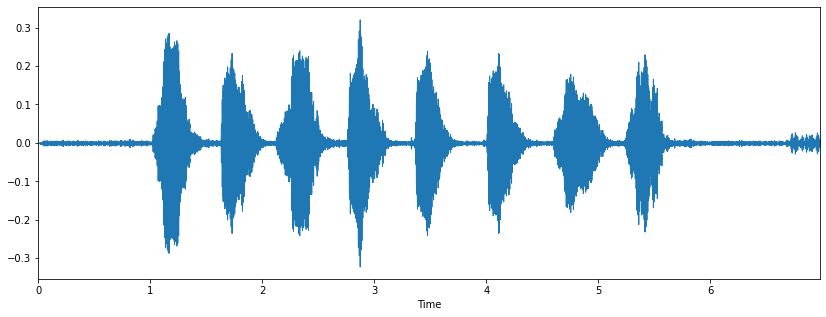

In [4]:
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

Построим спектрограмму загруженной вавки

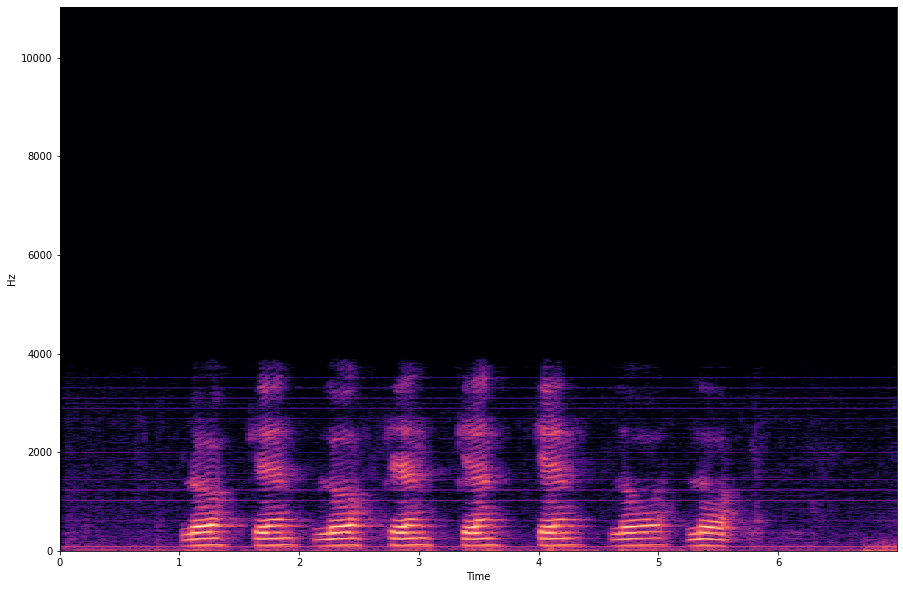

In [5]:
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

### 1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 

Сигнал для Yes имеет высокую энергию в области до 3000 Гц, сигнал для No имеет основную энергию только до 1000 Гц

### 2. В каких частотах находится основная энергия этого речевого сигнала?

Вся энергия находится до 4000 Гц, а основная часть до 1000 Гц

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [6]:
def mel(spec):
    #spec - stft spectrogram
    
    # YOUR CODE HERE
    return 2595 * np.log10(1 + spec / 700)

In [7]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "
    print("All ok!")

test_mel()

All ok!


# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
<!-- Реализуйте функцию вычисления fbank по формулам библиотеки librosa.  -->

### Мел-фильтры

Реализуйте функцию вычисления fbank.
Помимо лекций описание формул можно посмотреть тут: https://studbooks.net/2037683/informatika/raschyot_filtrov. 

In [8]:
def mel_filters_pure(sr, n_fft, n_mels):
    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]

    # YOUR CODE HERE
    mel_f = np.linspace(0, mel(sr / 2), n_mels + 2)
    mel_f = 700 * (10 ** (mel_f / 2595) - 1)
    bin = np.floor((n_fft + 1) * mel_f / sr)

    fbanks = np.zeros((n_mels, int(1 + n_fft // 2)))
    for m in range(1, n_mels + 1):
        f_m_minus, f_m, f_m_plus = int(bin[m - 1]), int(bin[m]), int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbanks[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbanks[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    return fbanks

Обратите внимание что реализации базовых функций таких как вычисления fbank могут отличаться в различных широко используемых библиотеках. Как правило это не критично для большинства практических задач, но бывают сложности при поиске ошибок и сравнении реализаций. 
Реализуйте функцию вычисления fbank по формулам библиотеки librosa по аналогии с открытым исходным кодом. Формулы, используемые в библиотеке librosa, отличаются от используемых в лекциях и некоторых других источниках. Обратите внимание на использование np.diff и np.substract, а также на нормализацию slaney. https://librosa.org/doc/latest/_modules/librosa/filters.html#mel

In [9]:
def mel_filters_librosa(sr, n_fft, n_mels):
    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]

    # YOUR CODE HERE

    weights = np.zeros((n_mels, int(1 + n_fft // 2)))
    fftfreqs = np.linspace(0, sr / 2, 1 + n_fft // 2)

    mel_f = np.linspace(mel(0), mel(sr / 2), n_mels + 2)
    mel_f = 700 * (10 ** (mel_f / 2595) - 1)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]
        weights[i] = np.maximum(0, np.minimum(lower, upper))
    
    enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])
    weights *= enorm[:, np.newaxis]

    return weights

In [10]:
assert mel_filters_librosa(32, 46, 4).shape == (4, 24) and \
    mel_filters_librosa(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters_librosa(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4, htk=True))
assert np.allclose(mel_filters_librosa(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40, htk=True))
print("All ok!")

All ok!


Сравним графически разницу реализаций

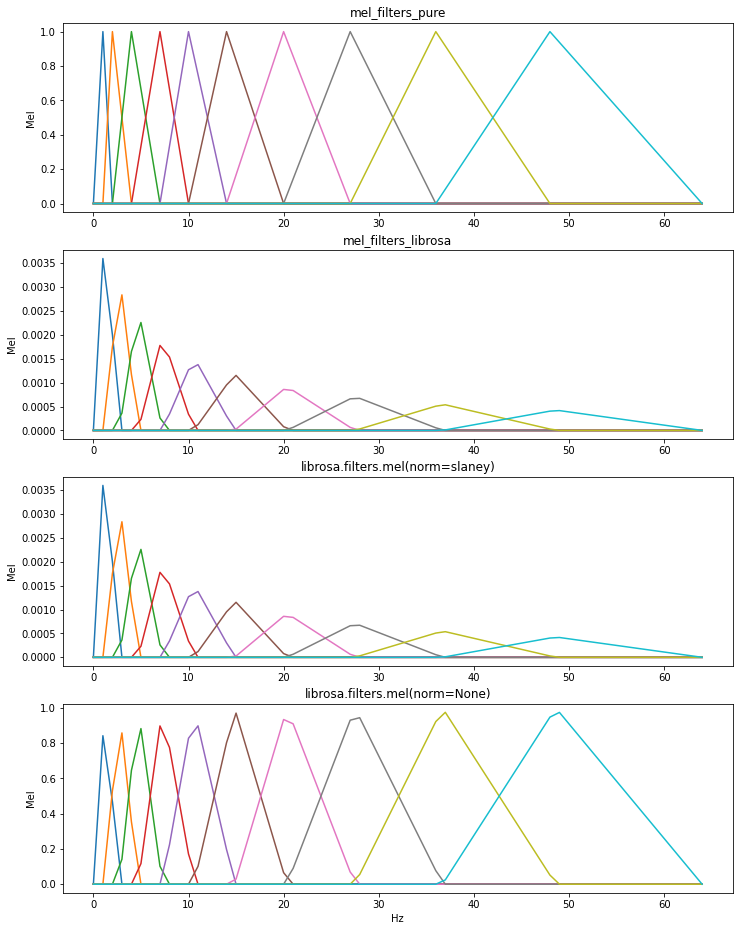

In [11]:
plt.figure(figsize=(12, 16))

sr, n_fft, n_mels = 22050, 128, 10

methods = {
    'mel_filters_pure': mel_filters_pure(sr, n_fft, n_mels),
    'mel_filters_librosa': mel_filters_librosa(sr, n_fft, n_mels),
    'librosa.filters.mel(norm=slaney)': librosa.filters.mel(sr, n_fft, n_mels, norm='slaney', htk=True),
    'librosa.filters.mel(norm=None)': librosa.filters.mel(sr, n_fft, n_mels, norm=None, htk=True)
}

for i, (method_name, method) in enumerate(methods.items()):
    plt.subplot(len(methods), 1, i + 1)
    for filter in method:
        plt.plot(filter)
    plt.title(method_name)
    plt.ylabel('Mel')

plt.xlabel('Hz')
plt.show()

Без нормализации slaney у трегольников одинаковая высота

Можно заметить, что есть небольшое расхождение в результатах формул. Для большенства практических задач это не существенно, но эти различия полезно знать при собственных экспериментах с аудио фичами а так же в случаях отладки и поиске ошибок.

Далее будем использовать функцию *mel_filters_librosa*

In [12]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]
    
    # YOUR CODE HERE
    
    n_fft, hop_length = window_ms * sr // 1000, step_ms * sr // 1000
    mel_filters = mel_filters_librosa(sr, n_fft, n_fbanks)
    spectrogram = np.abs(librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, win_length=n_fft)) ** 2
    return mel_filters @ spectrogram

In [13]:
def test_fbank(wav, sr, window_ms=25, step_ms=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_ms * sr//1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks, htk=True)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_ms=step_ms, n_fbanks=n_fbanks)

    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
        return 1

    if not np.allclose(fbanks_lib, fbanks):
        print('TEST PASSED BUT WITH CALCULATION ERROR')
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return np.mean(np.abs(fbanks_lib - fbanks))
        
    print("TEST PASSED")
    return 0

assert test_fbank(wav[:sr*1], sr) <= 0.0003, "1 sec wav test failed"
assert test_fbank(wav, sr) <= 0.0003, "All wav test failed"
print("All ok!")

TEST PASSED
TEST PASSED
All ok!


In [14]:
window_ms = 25
step_ms = 10
n_fbanks = 40
n_fft = window_ms * sr//1000
hop_length = step_ms * sr//1000

Визуализируем полученные фильтрбанки самописными функциями и функциями либросы:

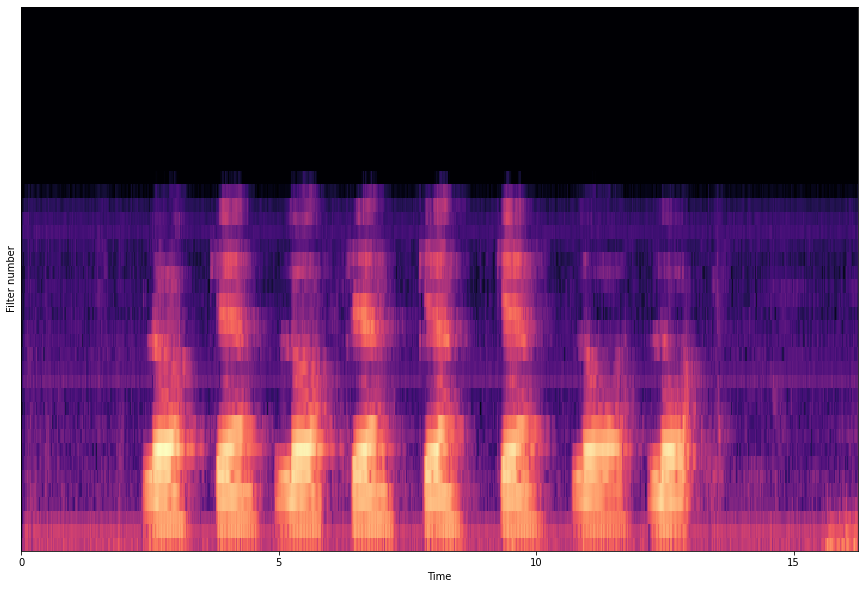

In [15]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(librosa.power_to_db(fbanks), sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

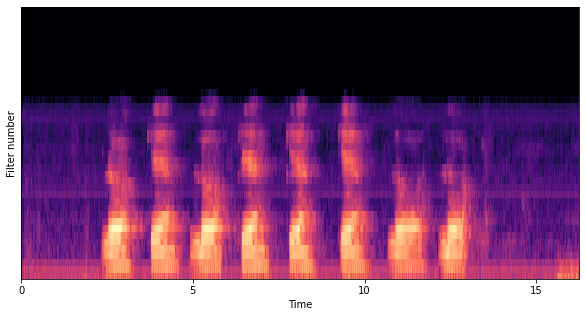

In [16]:
fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks, htk=True)
plt.figure(figsize=(10,5))
librosa.display.specshow(librosa.power_to_db(fbanks_lib), sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 4 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [17]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_mfcc=13):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    
    # YOUR CODE HERE
    mel_spec = get_fbanks(wav, sr, window_ms, step_ms, 128)
    # n_mels=128 - значение по умолчанию в librosa.feature.mfcc
    
    log_spec = 10 * np.log10(mel_spec)
    log_spec = np.maximum(log_spec, log_spec.max() - 80)

    return scipy.fftpack.dct(log_spec, type=2, norm='ortho', axis=0)[:n_mfcc]

Возможно, появится ошибка вычислений. Надо просто смириться с тем, что она есть, и сделать так, чтобы она была ниже допустимой:

In [18]:
def test_mfcc(wav, sr, window_ms=25, step_ms=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_ms * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, htk=True)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_ms=step_ms, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST PASSED BUT WITH CALCULATION ERROR!")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
        return 1

    if not np.allclose(mfcc_lib, mfcc):
        print("TEST PASSED BUT WITH CALCULATION ERROR")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return np.mean(np.abs(mfcc_lib - mfcc))

    print("TEST PASSED")
    return 0

assert test_mfcc(wav[:sr*1], sr) <= 0.0005, "1 sec wav test failed"
assert test_mfcc(wav, sr) <= 0.0005, "All wav test failed"
print("All ok!")

TEST PASSED BUT WITH CALCULATION ERROR
Average diff is 7.253214755798774e-06
TEST PASSED BUT WITH CALCULATION ERROR
Average diff is 4.971779094407498e-06
All ok!


Визуализируем *mfcc*

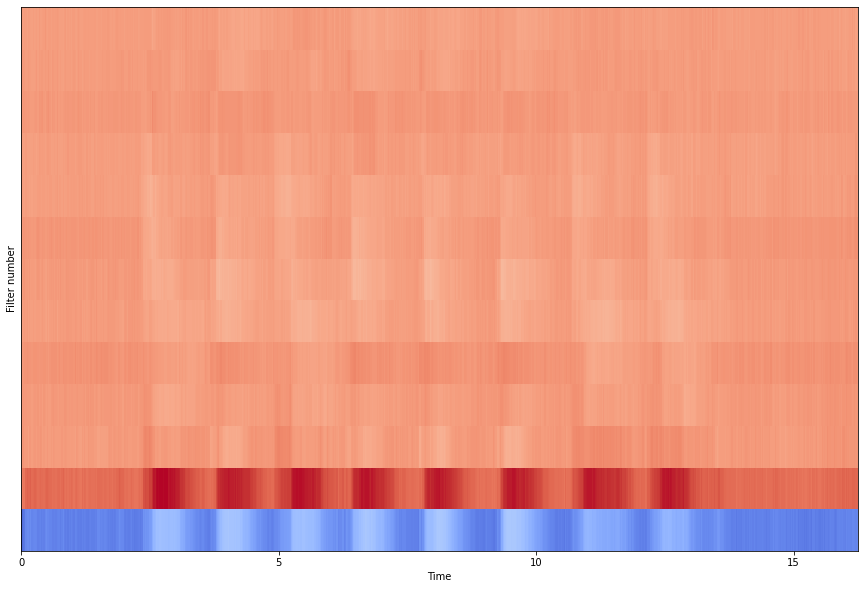

In [19]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [20]:
def load_yn_dataset(directory):
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

Послушаем одну вавку:

In [21]:
wav, sr = librosa.load("waves_yesno/0_1_0_1_0_0_0_0.wav")
ipd.Audio(wav, rate=sr)

Отделим 20% для теста

In [22]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *5 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре.
Реализуйте простой VAD. Настройте VAD, чтобы хорошо определялись границы слов.

Подсказка:
Можно отличать паузу от речи по энергии mfcc спектра( или части спектра). Чтобы предотвратить скачки на краях слов, воспользуйтесь сверткой со сглаживающим окном, например, Ханна.

In [23]:
# YOUR CODE HERE

# train_VA = # List[np.ndarray]. 1 - Voice, 0 - silence
# test_VA = # List[np.ndarray]. 1 - Voice, 0 - silence

def conv(x, window):
    return scipy.signal.convolve(x, np.ones(window), "same") / window

def VAD(x, sr=sr, return_same_length=True):
    window_ms, step_ms = 25, 10
    window, threshold = 10, 200

    mfcc = get_mfcc(x, sr=sr, window_ms=window_ms, step_ms=step_ms)
    mfcc = conv(mfcc[1, :], window) - threshold

    res = np.zeros(len(mfcc))
    res[mfcc > 0] = 1

    if return_same_length:
        res = np.repeat(res, step_ms * sr // 1000)
        if len(res) < len(x):
            res = np.concatenate((res, np.zeros(len(x) - len(res))))
        elif len(x) < len(res):
            res = res[:len(x)]

    return res

In [24]:
train_VA = [VAD(x) for x in X_train]
test_VA = [VAD(x) for x in X_test]

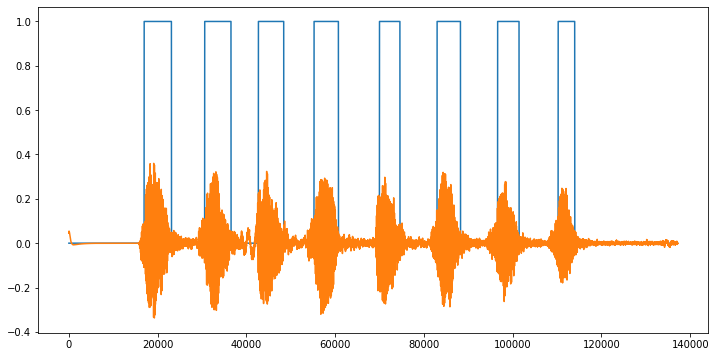

In [25]:
idx = 0
plt.figure(figsize=(12, 6))
plt.plot(train_VA[idx])
plt.plot(X_train[idx])
plt.show()

In [26]:
def test_VAD(VOICE, VA, Y, min_acc=0.95):
    def check_ali(ali, num_words):
        diff = ali[1:]  - ali[:-1]
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() == num_words:
            return -2
        return 0
    
    bad_i = []
    err =0
    for i, (ali, y) in enumerate(zip(VA, Y)):
        assert len(VOICE[i]) == len(ali), "shapes doesn't match"
        if check_ali(ali, len(y)) != 0:
            bad_i.append(i)
            err+=1
    acc = (len(Y) - err)/len(Y)
    print(f"Accuracy {acc}")
    if len(bad_i) >0:
        print(f"ids with error {bad_i}")
    assert acc >= min_acc , f"Accuracy must be >= {min_acc}"
    print("Test passed")

test_VAD(X_train, train_VA, Y_train)
test_VAD(X_test, test_VA, Y_test)
print("VAD ok!")

Accuracy 1.0
Test passed
Accuracy 1.0
Test passed
VAD ok!


# Задание *6 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки выделеных VAD'ом слов. Или любым другим удобным для вас способом. Добейтесь точности больше 0.95

In [27]:
# YOUR CODE HERE
def make_dataset(X, y, vad, sr=sr):
    features, target = [], []

    for i, (x_i, y_i, vad_i) in enumerate(zip(X, y, vad)):
        mfcc = get_mfcc(x_i, sr=sr)
        idx = np.where(vad_i[1:] != vad_i[:-1])[0] + 1

        for j in range(0, len(idx), 2):
            features.append(np.mean(mfcc[:, idx[j]:idx[j+1]], axis=1))
            target.append(y_i[j // 2])
            
    return np.array(features), np.array(target)

train_VA = [VAD(x, return_same_length=False) for x in X_train]
test_VA = [VAD(x, return_same_length=False) for x in X_test]

x_train, y_train = make_dataset(X_train, Y_train, train_VA)
x_test, y_test = make_dataset(X_test, Y_test, test_VA)

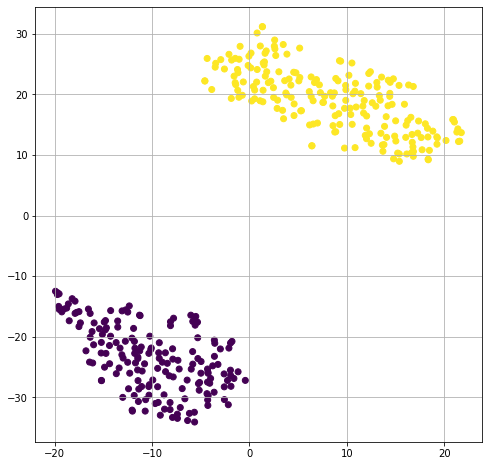

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE()
y_2d = tsne.fit_transform(x_train)

plt.figure(figsize=(8, 8))
plt.scatter(y_2d[:, 0], y_2d[:, 1], c=y_train)
plt.grid()
plt.show()

Данные скорее всего линейно разделимы, обучим обычную логистическую регрессию

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(x_train, y_train)
print(f'Accuracy = {accuracy_score(y_test, clf.predict(x_test))}')

Accuracy = 1.0


### Результаты

Визуализируйте кривые обучения классификатора или приведите логи обучения

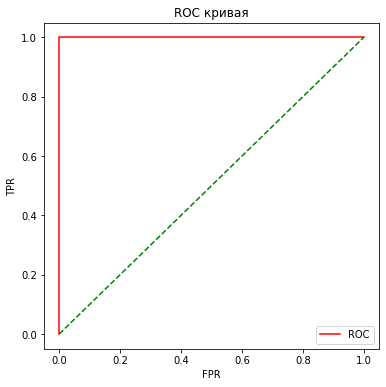

In [30]:
# YOUR CODE HERE
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, clf.predict(x_test))

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC кривая')
plt.legend()
plt.show()